In [2]:
import csv
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

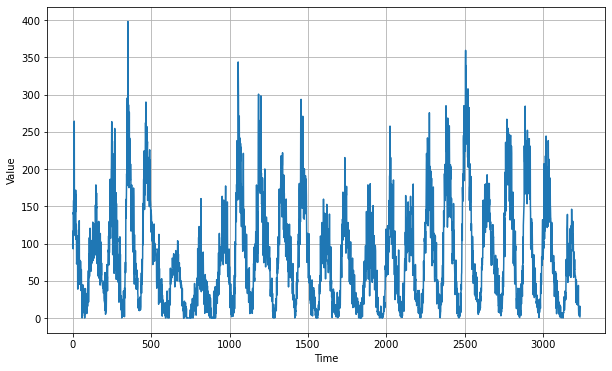

In [5]:
time_step = []
sunspots = []

with open('sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

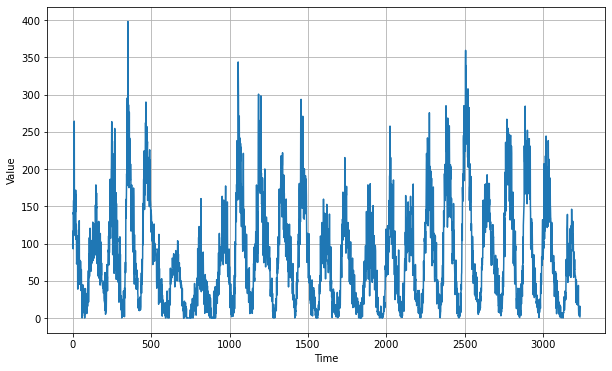

In [6]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [7]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 7s 613ms/step - loss: 79.8340 - mae: 80.3314
Epoch 2/100
12/12 [==============================] - 7s 557ms/step - loss: 78.0944 - mae: 78.5918
Epoch 3/100
12/12 [==============================] - 7s 576ms/step - loss: 75.4519 - mae: 75.9497
Epoch 4/100
12/12 [==============================] - 6s 534ms/step - loss: 72.2679 - mae: 72.7658
Epoch 5/100
12/12 [==============================] - 6s 514ms/step - loss: 68.7693 - mae: 69.2672
Epoch 6/100
12/12 [==============================] - 7s 546ms/step - loss: 65.1128 - mae: 65.6099
Epoch 7/100
12/12 [==============================] - 7s 556ms/step - loss: 61.5272 - mae: 62.0241
Epoch 8/100
12/12 [==============================] - 6s 533ms/step - loss: 58.1406 - mae: 58.6369
Epoch 9/100
12/12 [==============================] - 7s 558ms/step - loss: 55.0732 - mae: 55.5697
Epoch 10/100
12/

12/12 [==============================] - 6s 482ms/step - loss: 24.2161 - mae: 24.7099
Epoch 83/100
12/12 [==============================] - 6s 482ms/step - loss: 30.2518 - mae: 30.7467
Epoch 84/100
12/12 [==============================] - 6s 484ms/step - loss: 40.5526 - mae: 41.0490
Epoch 85/100
12/12 [==============================] - 6s 479ms/step - loss: 59.5834 - mae: 60.0816
Epoch 86/100
12/12 [==============================] - 6s 483ms/step - loss: 49.3181 - mae: 49.8159
Epoch 87/100
12/12 [==============================] - 6s 484ms/step - loss: 50.5876 - mae: 51.0851
Epoch 88/100
12/12 [==============================] - 6s 484ms/step - loss: 52.3386 - mae: 52.8368
Epoch 89/100
12/12 [==============================] - 6s 482ms/step - loss: 53.5402 - mae: 54.0381
Epoch 90/100
12/12 [==============================] - 6s 489ms/step - loss: 53.5899 - mae: 54.0881
Epoch 91/100
12/12 [==============================] - 6s 495ms/step - loss: 52.3949 - mae: 52.8929
Epoch 92/100
12/12 [===

(1e-08, 0.0001, 0.0, 60.0)

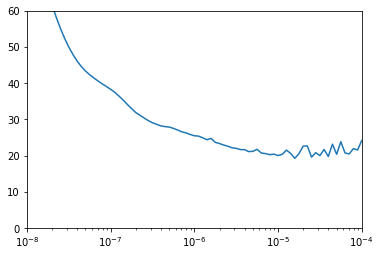

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500,verbose=2)

Epoch 1/500
30/30 - 9s - loss: 38.9180 - mae: 39.4144
Epoch 2/500
30/30 - 8s - loss: 25.7638 - mae: 26.2582
Epoch 3/500
30/30 - 8s - loss: 22.0794 - mae: 22.5731
Epoch 4/500
30/30 - 9s - loss: 20.4759 - mae: 20.9689
Epoch 5/500
30/30 - 8s - loss: 19.7143 - mae: 20.2067
Epoch 6/500
30/30 - 8s - loss: 19.3127 - mae: 19.8048
Epoch 7/500
30/30 - 8s - loss: 18.7530 - mae: 19.2454
Epoch 8/500
30/30 - 8s - loss: 18.1366 - mae: 18.6282
Epoch 9/500
30/30 - 8s - loss: 18.1508 - mae: 18.6423
Epoch 10/500
30/30 - 9s - loss: 19.7775 - mae: 20.2696
Epoch 11/500
30/30 - 7s - loss: 18.0412 - mae: 18.5329
Epoch 12/500
30/30 - 8s - loss: 18.2161 - mae: 18.7076
Epoch 13/500
30/30 - 8s - loss: 17.6201 - mae: 18.1109
Epoch 14/500
30/30 - 8s - loss: 17.7330 - mae: 18.2236
Epoch 15/500
30/30 - 8s - loss: 17.6552 - mae: 18.1461
Epoch 16/500
30/30 - 7s - loss: 17.4794 - mae: 17.9698
Epoch 17/500
30/30 - 7s - loss: 17.6270 - mae: 18.1178
Epoch 18/500
30/30 - 7s - loss: 17.5572 - mae: 18.0478
Epoch 19/500
30/30 

30/30 - 5s - loss: 15.9289 - mae: 16.4176
Epoch 150/500
30/30 - 5s - loss: 15.9568 - mae: 16.4456
Epoch 151/500
30/30 - 5s - loss: 16.0001 - mae: 16.4891
Epoch 152/500
30/30 - 5s - loss: 15.9823 - mae: 16.4712
Epoch 153/500
30/30 - 5s - loss: 16.0725 - mae: 16.5613
Epoch 154/500
30/30 - 5s - loss: 15.9669 - mae: 16.4556
Epoch 155/500
30/30 - 5s - loss: 15.9624 - mae: 16.4512
Epoch 156/500
30/30 - 6s - loss: 15.9894 - mae: 16.4780
Epoch 157/500
30/30 - 6s - loss: 15.8940 - mae: 16.3824
Epoch 158/500
30/30 - 6s - loss: 16.0074 - mae: 16.4958
Epoch 159/500
30/30 - 6s - loss: 15.9764 - mae: 16.4654
Epoch 160/500
30/30 - 5s - loss: 15.9434 - mae: 16.4319
Epoch 161/500
30/30 - 5s - loss: 15.8487 - mae: 16.3372
Epoch 162/500
30/30 - 5s - loss: 16.0157 - mae: 16.5049
Epoch 163/500
30/30 - 5s - loss: 15.9404 - mae: 16.4292
Epoch 164/500
30/30 - 5s - loss: 15.8350 - mae: 16.3236
Epoch 165/500
30/30 - 6s - loss: 15.8571 - mae: 16.3459
Epoch 166/500
30/30 - 6s - loss: 15.8355 - mae: 16.3241
Epoch 

Epoch 296/500
30/30 - 6s - loss: 15.1306 - mae: 15.6175
Epoch 297/500
30/30 - 6s - loss: 15.1299 - mae: 15.6167
Epoch 298/500
30/30 - 6s - loss: 15.2661 - mae: 15.7536
Epoch 299/500
30/30 - 5s - loss: 15.0537 - mae: 15.5403
Epoch 300/500
30/30 - 5s - loss: 15.2413 - mae: 15.7286
Epoch 301/500
30/30 - 5s - loss: 15.0857 - mae: 15.5728
Epoch 302/500
30/30 - 5s - loss: 15.0120 - mae: 15.4985
Epoch 303/500
30/30 - 5s - loss: 15.2021 - mae: 15.6892
Epoch 304/500
30/30 - 6s - loss: 15.1372 - mae: 15.6243
Epoch 305/500
30/30 - 6s - loss: 15.0877 - mae: 15.5744
Epoch 306/500
30/30 - 6s - loss: 15.0093 - mae: 15.4958
Epoch 307/500
30/30 - 6s - loss: 15.1151 - mae: 15.6019
Epoch 308/500
30/30 - 6s - loss: 14.9850 - mae: 15.4717
Epoch 309/500
30/30 - 6s - loss: 15.0047 - mae: 15.4910
Epoch 310/500
30/30 - 6s - loss: 15.1455 - mae: 15.6327
Epoch 311/500
30/30 - 5s - loss: 15.1788 - mae: 15.6658
Epoch 312/500
30/30 - 5s - loss: 15.0867 - mae: 15.5735
Epoch 313/500
30/30 - 6s - loss: 15.0325 - mae: 

Epoch 443/500
30/30 - 7s - loss: 14.5468 - mae: 15.0324
Epoch 444/500
30/30 - 6s - loss: 14.4956 - mae: 14.9811
Epoch 445/500
30/30 - 5s - loss: 14.5007 - mae: 14.9860
Epoch 446/500
30/30 - 5s - loss: 14.5422 - mae: 15.0279
Epoch 447/500
30/30 - 5s - loss: 14.5392 - mae: 15.0246
Epoch 448/500
30/30 - 5s - loss: 14.5301 - mae: 15.0158
Epoch 449/500
30/30 - 5s - loss: 14.4266 - mae: 14.9114
Epoch 450/500
30/30 - 5s - loss: 14.4687 - mae: 14.9540
Epoch 451/500
30/30 - 5s - loss: 14.4794 - mae: 14.9646
Epoch 452/500
30/30 - 5s - loss: 14.4481 - mae: 14.9336
Epoch 453/500
30/30 - 5s - loss: 14.4533 - mae: 14.9384
Epoch 454/500
30/30 - 5s - loss: 14.4942 - mae: 14.9796
Epoch 455/500
30/30 - 5s - loss: 14.4246 - mae: 14.9098
Epoch 456/500
30/30 - 5s - loss: 14.5146 - mae: 15.0000
Epoch 457/500
30/30 - 5s - loss: 14.6728 - mae: 15.1588
Epoch 458/500
30/30 - 5s - loss: 14.4382 - mae: 14.9233
Epoch 459/500
30/30 - 6s - loss: 14.5093 - mae: 14.9948
Epoch 460/500
30/30 - 5s - loss: 14.4530 - mae: 

In [13]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

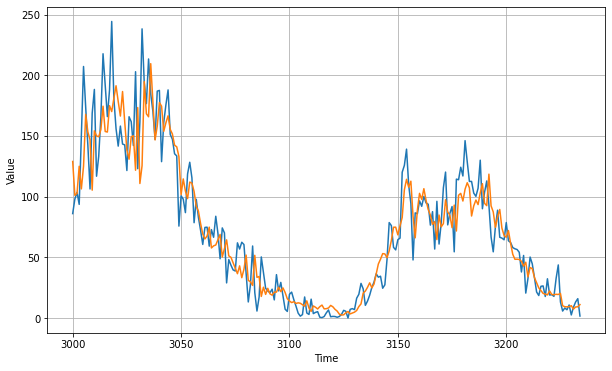

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.108611

<Figure size 432x288 with 0 Axes>

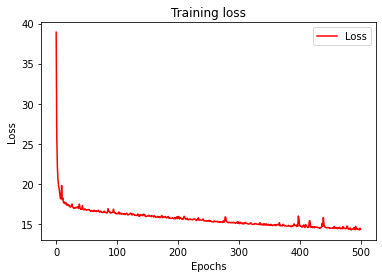

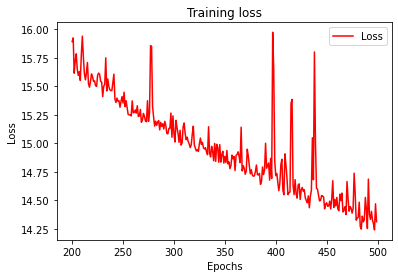

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [17]:
print(rnn_forecast)

[128.9372    101.06748   102.62812   124.9748    106.351555  124.983826
 167.7347    153.2618    146.9506    105.31676   154.21713   150.01387
 149.26974   155.22224   174.5119    153.64067   153.19695   174.92628
 170.05923   180.99638   191.34045   178.39764   166.36002   186.57297
 161.59938   138.33205   130.82523   149.17076   150.15419   121.72575
 173.32436   110.80545   125.489555  194.80057   168.25594   165.76596
 209.52864   178.31754   146.72043   158.04416   177.48102   174.493
 153.7925    160.84966   166.557     155.42154   151.5064    142.37834
 141.0081    132.99486   101.568535  114.57091   104.5748     98.354256
 111.97845   111.12342   104.23479    92.07804    88.06186    77.77121
  69.139305   65.12631    67.570915   74.828766   57.698547   59.43362
  60.112644   64.484024   68.85234    50.23483    57.088577   64.36292
  51.161186   49.98807    45.420372   40.942852   36.47843    42.93267
  33.195972   40.155342   51.827274   30.958202   29.850954   26.830112
  51.